# Table Topper

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import sin, log10, cos, atan2, hypot
from FT_model import model_FT
from numpy.fft import fft2
from numpy.fft import ifft2
from numpy.fft import fftshift
from numpy.fft import ifftshift
from mpl_toolkits.axes_grid1 import make_axes_locatable
from symmetry import create_symmetry
from radial_gradient import RWGE
from power_region import power_ratio

image_path = "Images/"

In [2]:
def generate_spiral(gridsize, aperture, r_max, r_min, splits, settings):
    split = splits
    first = settings[0]
    second = settings[1]
    third = settings[2]
    fourth = settings[3]
    
    sampling = aperture/(gridsize//2)
    wfarr = np.zeros([gridsize, gridsize], dtype = np.complex128)
    c = gridsize//2
    for i in range(gridsize):
        for j in range(gridsize):
            x = i - c
            y = j - c
            phi = atan2(y, x)
            r = sampling*hypot(x,y)
            wfarr[i][j] = spiral(r, phi, aperture, r_max, r_min, split, first, second, third, fourth)
    return wfarr

def spiral(r, phi, aperture, r_max, r_min, split, first, second, third, fourth):
    # Spiral parameters
    alpha1 = 20.186
    m1 = 5
    eta1 = -1.308
    m2 = -5
    alpha2 = 16.149
    eta2 = -0.733
    m3 = 10
    alpha3 = 4.0372
    eta3 = -0.575
    
    white = np.complex(1,0)
    black = -np.complex(1,0)
    v = np.complex(0,0)
    offset = np.complex(-(3**0.5)/2,1/2)
#     black = offset

    if (r<=r_max and r>r_min):
        logr = log10(r)
        chi1 = alpha1*logr+m1*phi+eta1
        c1 = cos(chi1)
        chi2 = alpha2*logr+m2*phi+eta2
        c2 = cos(chi2)
        chi3 = alpha3*logr+m3*phi+eta3
        c3 = sin(chi3)
        
        z = 0 if (c1*c2*c3>0) else 1 
        for i in range(len(split)):
            if (r <= split[i] and r > split[i+1]): # Finds which region we are in
                
                if i%2 != 0:
                    z = np.abs(z-1)
                
                # First quadrant
                if c3 < 0 and sin(chi3/2.) <= 0:
                    return black if first[i][z] else white

                # Second qudrant
                elif c3 >= 0 and sin(chi3/2.) <= 0:
                    return black if second[i][np.abs(z-1)] else white
#                     return black if second[i][z] else white
                
                # Third quadrant
                elif c3 < 0 and sin(chi3/2.) > 0:
                    return black if third[i][z] else white
        
                # Fourth qudrant
                else: 
                    return black if fourth[i][np.abs(z-1)] else white
#                     return black if fourth[i][z] else white
#             else:
#                 print("Missing Values")
                    
    elif r < r_min:
        v = black
#         v = np.complex(0,0)
    return v

In [3]:
def modify_FT(FT, p, sig1, sig2, mult):
    shape = np.shape(FT)
    out = np.zeros(shape)
    mu = shape[0]//2
    for i in range(shape[0]):
        for j in range(shape[1]):
            Z = FT[i][j]
            g1 = gaussian(i, j, p, mu, sig1)
            g2 = gaussian(i, j, p, mu, sig2)
            G = g1-g2
#             G = g1
            if G < 0:
                G = 0
            if not mult:
#                 out[i][j] = G*(Z/np.abs(Z))
                phi = np.angle(Z)
                mag = G
                out[i][j] = mag*np.exp(1j*phi)
            else:
                 out[i][j] = G*Z
    return out

def gaussian(x, y, p, mu, sig):
    a = 1 / (sig * np.sqrt(2 * np.pi)) 
    b = ((x-mu)**2)/(2*sig**2)
    c = ((y-mu)**2)/(2*sig**2)
    g_out = a*np.exp(-(b+c)**p)
    return g_out

def binarise(wf, aperture, r_max):
    gridsize = np.shape(wf)[0]
    sampling = aperture/(gridsize//2)
    wfarr = np.zeros([gridsize, gridsize], dtype = np.complex128)
    c = gridsize//2
    
    white = np.complex(1,0)
    black = -np.complex(1,0)
    v = np.complex(0,0)
    
#     R = []
#     A = []
    
    for i in range(gridsize):
        for j in range(gridsize):
            x = i - c
            y = j - c
            r = sampling*hypot(x,y)
#             R.append(r)
            if r > r_max:
                wfarr[i][j] = v
            else:
#                 wfarr[i][j] = black if np.angle(wf[i][j])/2 >= 1/(2**0.5) else white
                wfarr[i][j] = black if np.abs(np.angle(wf[i][j])) > np.pi/2 else white
#                 wfarr[i][j] = black if np.abs(np.angle(wf[i][j])) > np.pi/4 else white
#             A.append(np.angle(wf[i][j]))
    
    return wfarr

def iterate(wf, p, sig1, sig2, aperture, r_max, mult=False, sym=True):
    PSF = fft2(wf)
    PSF_mod = ifftshift(modify_FT(fftshift(PSF), p, sig1, sig2, mult))
    IFT = ifft2(PSF_mod)
    
    # symmertise before binarise
    if sym:
        wf_out = create_symmetry(IFT, 10)
    wf_out = binarise(wf_out, aperture*1e3, r_max)
        
    # symmertise after binarise
#     wf_out = binarise(IFT, aperture*1e3, r_max)
#     if sym:
#         wf_out = create_symmetry(wf_out, 10)

    return PSF, PSF_mod, IFT, wf_out

In [4]:
gridsize = 2048//4
x = range(gridsize)
y = range(gridsize)
X, Y = np.meshgrid(x, y)
A = np.zeros([gridsize, gridsize])
c = gridsize//2
mu = c
p = 10
sig = 150
for i in range(gridsize):
    for j in range(gridsize):
        x = i - c
        y = j - c
        
        g1 = gaussian(i, j, p, mu, sig)
        g2 = gaussian(i, j, p, mu, sig/20)
        G = g1-g2
        if G < 0:
            G = 0
        A[i][j] = G

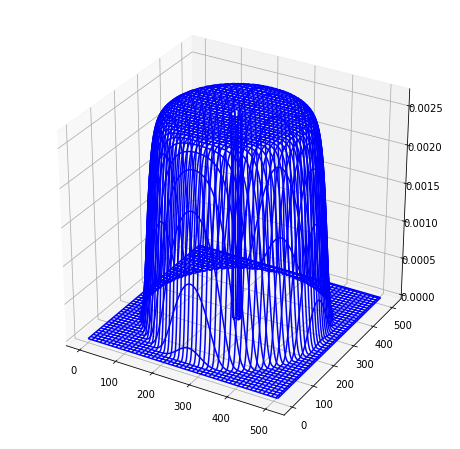

In [5]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X, Y, A, color='b')
plt.show()

In [6]:
a = 3
b = 1

aperture = 0.015*a               # Aperture (m)
gridsize = 1024*b                # Gridsize of the wavefront array
npixels = 1024*b                 # Size of detector, in pixels
wl = 0.525e-9                    # Wavelength values (micrometers)
fl = 0.15                        # Focal length (m)
detector_pitch = 1.12e-6         # m/pixel on detector (pixel spacing)
splits=[15.15, 12.4, 10.17, 8.33, 6.83, 5.6, 4.6, 3.75, 3.05, 2.5, 2.07, 1.7, 1.4, 1.14, 0.925, 0.76, 0.62]
r_max = splits[1]

first  = [[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,1],[1,1],[1,0],[0,1],[1,0],[0,1]]
second = [[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,1],[1,1],[1,1],[0,1],[1,0],[0,1],[1,1]]
third  = [[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,1],[1,1],[1,0],[0,1],[1,0],[0,1]]
fourth = [[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,1],[1,1],[1,1],[0,1],[1,0],[0,1],[1,1]]
settings = [first, second, third, fourth]
design = "Orig"

# first =  [[0, 1], [1, 0], [1, 1], [0, 1], [0, 0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,1],[1,1],[1,0],[0,1],[1,0],[0,1]]
# second = [[0, 1], [0, 1], [0, 1], [1, 0], [0, 1],[1,0],[0,1],[1,0],[0,1],[1,1],[1,1],[1,1],[0,1],[1,0],[0,1],[1,1]]
# third =  [[0, 0], [1, 1], [1, 0], [1, 0], [1, 0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,1],[1,1],[1,0],[0,1],[1,0],[0,1]]
# fourth = [[1, 1], [0, 0], [1, 0], [1, 0], [1, 1],[1,0],[0,1],[1,0],[0,1],[1,1],[1,1],[1,1],[0,1],[1,0],[0,1],[1,1]]
# settings = [first, second, third, fourth]
# design = "Optimal_half"

# first =  [[0, 1], [0, 1], [1, 0], [0, 0], [1, 0], [1, 0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,1],[1,1],[1,0],[0,1],[1,0],[0,1]] 
# second = [[0, 1], [1, 0], [0, 1], [1, 1], [0, 1], [0, 1],[1,0],[0,1],[1,0],[0,1],[1,1],[1,1],[1,1],[0,1],[1,0],[0,1],[1,1]]
# third =  [[0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,1],[1,1],[1,0],[0,1],[1,0],[0,1]]
# fourth = [[0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1],[1,0],[0,1],[1,0],[0,1],[1,1],[1,1],[1,1],[0,1],[1,0],[0,1],[1,1]]
# settings = [first, second, third, fourth]
# design = "Optimal_full"

p = 10
sig1 = a*9
sig2 = sig1/20 

In [ ]:
%%time

# Generate initial pupil
wf = generate_spiral(gridsize, aperture*1e3, splits[0], splits[-7], splits, settings)
wf_out = wf
PSF_out = fft2(wf_out)
PSF_real = np.abs(fftshift(PSF_out))**2

# Input paramaters
mult = False
sym = True
sig = 9
ratio = 20
p = 10
sig1 = sig
sig2 = sig/ratio

# Display settings
size = 200
fsize = (16,16)
c = gridsize//2

Heuristics = []

for i in range(-1, 5):
    print(i, end='')
        
    fig, axs = plt.subplots(1, 2, figsize=fsize)
    ax = axs[0]
    ax.set_title("Pupil {}".format(i))
    im = ax.imshow(np.abs(np.angle(wf_out)))
    plt.colorbar(im, cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))

    ax = axs[1]
    ax.set_title("PSF {}".format(i))
    im = ax.imshow(PSF_real[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)])
    circle = plt.Circle((512, 512), 20, color='r', fill=False)
    ax.add_artist(circle)
    plt.colorbar(im, cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))
    
    E = RWGE(PSF_real)
    R = power_ratio(PSF_real, 39)
    P = np.max(PSF_real)
    C = PSF_real[PSF_real.shape[0]//2][PSF_real.shape[0]//2]
    Heuristics.append([i, E, R, P, C])
    
    fig.savefig(image_path + "{}_{}_{}_{}_{}_{}_{}_{}_{}_:_{}_{}_{}_{}.jpg".format(design, mult, sym, sig, ratio, p, a, b, i, E*1e-16, R*100, P*1e-6 ,C*1e-6), dpi=fig.dpi, bbox_inches="tight", pad_inches=0.05)
    
    PSF, PSF_mod, IFT, wf_out = iterate(wf_out, p, sig1*a, sig2*a, aperture, r_max, mult, sym)
    PSF_out = fft2(wf_out)
    PSF_real = np.abs(fftshift(PSF_out))**2
        
fig, axs = plt.subplots(1, 2, figsize=fsize)
ax = axs[0]
ax.set_title("Pupil {}".format(i+1))
im = ax.imshow(np.abs(np.angle(wf_out)))
plt.colorbar(im, cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))

ax = axs[1]
ax.set_title("PSF {}".format(i+1))
im = ax.imshow(PSF_real[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)])
circle = plt.Circle((512, 512), 20, color='r', fill=False)
ax.add_artist(circle)
plt.colorbar(im, cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))

E = RWGE(PSF_real)
R = power_ratio(PSF_real, 39)
P = np.max(PSF_real)
C = PSF_real[PSF_real.shape[0]//2][PSF_real.shape[0]//2]
Heuristics.append([i + 1, E, R, P, C])
    
fig.savefig(image_path + "{}_{}_{}_{}_{}_{}_{}_{}_{}_:_{:.2f}_{:.2f}_{:.2f}_{:.2f}.jpg".format(design, mult, sym, sig, ratio, p, a, b, i+1, E*1e-16, R*100, P*1e-6 ,C*1e-6), dpi=fig.dpi, bbox_inches="tight", pad_inches=0.05)

-1

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


012

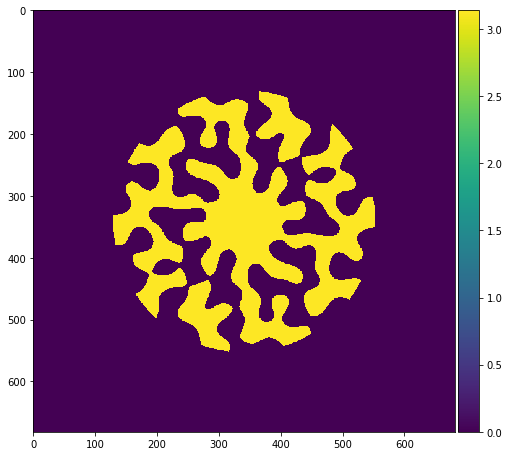

In [50]:
### Save as fits - PSF_out and wf_out
fsize = (8,8)
c = wf_out.shape[0]//2
size = 341*2
WF = wf_out[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]

fig, axs = plt.subplots(1, 1, figsize=fsize)
ax = axs
im = ax.imshow(np.abs(np.angle(WF)))
plt.colorbar(im, cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))
plt.show()

# from astropy.io import fits
# hdu = fits.PrimaryHDU(np.abs(np.angle(WF)))
# hdu.writeto('pupil.fits')

In [51]:
WF_sym = create_symmetry(WF, 10)

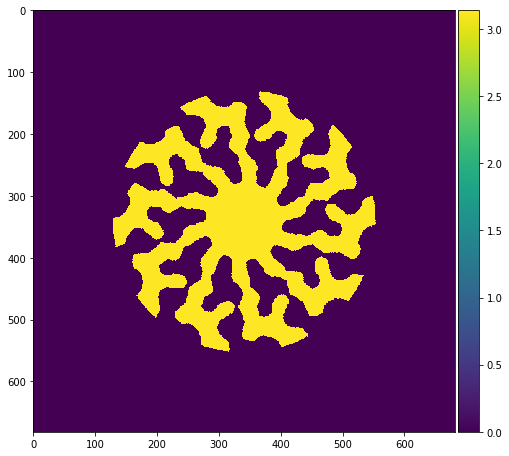

In [52]:
fig, axs = plt.subplots(1, 1, figsize=fsize)
ax = axs
im = ax.imshow(np.abs(np.angle(WF_sym)))
plt.colorbar(im, cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))
plt.show()

In [517]:
# P_out = fft2(generate_spiral(gridsize, aperture*1e3, splits[0], splits[-7], splits, settings))

In [602]:
# wf = generate_spiral(gridsize, aperture*1e3, splits[0], splits[-7], splits, settings)
# PSF = fft2(wf)
# PSF_mod = ifftshift(modify_FT(fftshift(PSF), p, sig1, sig2, mult=True))

# fsize = (10,10)
# fig, axs = plt.subplots(1, 1, figsize=fsize)
# c = gridsize//2
# size = 100
# d = size//2

# ax = axs

# ax.set_title("PSF")
# im = ax.imshow(np.abs(fftshift(PSF)[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]))
# # im = ax.imshow(np.abs(fftshift(PSF)))

# # ax.set_title("|PSF_mod|")
# # im = ax.imshow(np.abs(fftshift(PSF_mod)[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]))
# # plt.colorbar(im, cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))

# # circle = plt.Circle((d, d), 20, color='r', fill=False) # ~ 6lam/D
# circle = plt.Circle((d, d), 30, color='r', fill=False) # ~ 10lam/D
# ax.add_artist(circle)
# plt.colorbar(im, cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))
# plt.show()

In [601]:
# fsize = (16,16)
# fig, axs = plt.subplots(2, 2, figsize=fsize)
# c = gridsize//2
# size = 150

# ax = axs[0][0]
# im = ax.imshow(np.abs(np.angle(wf)))
# # im = ax.imshow(np.abs(wf))

# ax.set_title("angle(WF)")
# plt.colorbar(im, cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))

# # ax = axs[0][0]
# # ax.set_title("PSF")
# # im = ax.imshow(np.abs(fftshift(PSF)[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]))
# # plt.colorbar(im, cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))

# ax = axs[0][1]
# ax.set_title("|PSF_mod|")
# im = ax.imshow(np.abs(fftshift(PSF_mod)[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]))
# plt.colorbar(im, cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))

# ax = axs[1][0]
# ax.set_title("angle(wf_out)")
# im = ax.imshow(np.abs(np.angle(wf_out)))
# plt.colorbar(im, cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))

# ax = axs[1][1]
# ax.set_title("PSF_out")
# im = ax.imshow(np.abs(fftshift(PSF_out)[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)])**2)
# circle = plt.Circle((512, 512), 20, color='r', fill=False)
# ax.add_artist(circle)
# plt.colorbar(im, cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))

# plt.show()
# # print(print("i: {}, s: {}, p: {}, multiplied".format(i-1, s+1, p-1)))
# # print("Single filter, Multiplication")
# # print("Single filter, Magnitude")

--------------------------

In [593]:
# PSF = fft2(IFT_b)
# PSF_mod = ifftshift(modify_FT(fftshift(PSF), p, sig))
# IFT = ifft2(PSF_mod)
# IFT_c = binarise(IFT, aperture*1e3, r_max)

# fig, ax = plt.subplots(3, 2, figsize=fsize)
# c = gridsize//2
# size = 75

# im = ax[0][0].imshow(np.abs(np.angle(IFT_b)))
# ax[0][0].set_title("angle(WF)")
# plt.colorbar(im, cax=make_axes_locatable(ax[0][0]).append_axes("right", size="5%", pad=0.05))

# ax[0][1].set_title("|fftshift(FFT(WF))|**2")
# im = ax[0][1].imshow(np.abs(fftshift(PSF)[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)])**2)
# plt.colorbar(im, cax=make_axes_locatable(ax[0][1]).append_axes("right", size="5%", pad=0.05))

# ax[1][0].set_title("|fftshift(modify(FFT(WF)))|**2")
# im = ax[1][0].imshow(np.abs(fftshift(PSF_mod)[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)])**2)
# plt.colorbar(im, cax=make_axes_locatable(ax[1][0]).append_axes("right", size="5%", pad=0.05))

# ax[1][1].set_title("angle(IFFT(FFT(WF)))")
# im = ax[1][1].imshow(np.abs(np.angle(IFT)))
# plt.colorbar(im, cax=make_axes_locatable(ax[1][1]).append_axes("right", size="5%", pad=0.05))

# ax[2][0].set_title("angle(IFFT(FFT(WF)))")
# im = ax[2][0].imshow(np.abs(IFT))
# plt.colorbar(im, cax=make_axes_locatable(ax[2][0]).append_axes("right", size="5%", pad=0.05))

# ax[2][1].set_title("angle(binarise(IFFT(FFT(WF))))")
# im = ax[2][1].imshow(np.abs(np.angle(IFT_c)))
# plt.colorbar(im, cax=make_axes_locatable(ax[2][1]).append_axes("right", size="5%", pad=0.05))

# plt.show()

In [594]:
# PSF = fft2(IFT_c)
# PSF_mod = ifftshift(modify_FT(fftshift(PSF), p, sig))
# IFT = ifft2(PSF_mod)
# IFT_d = binarise(IFT, aperture*1e3, r_max)

# fig, ax = plt.subplots(3, 2, figsize=fsize)
# c = gridsize//2
# size = 75

# im = ax[0][0].imshow(np.abs(np.angle(IFT_c)))
# ax[0][0].set_title("angle(WF)")
# plt.colorbar(im, cax=make_axes_locatable(ax[0][0]).append_axes("right", size="5%", pad=0.05))

# ax[0][1].set_title("|fftshift(FFT(WF))|**2")
# im = ax[0][1].imshow(np.abs(fftshift(PSF)[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)])**2)
# plt.colorbar(im, cax=make_axes_locatable(ax[0][1]).append_axes("right", size="5%", pad=0.05))

# ax[1][0].set_title("|fftshift(modify(FFT(WF)))|**2")
# im = ax[1][0].imshow(np.abs(fftshift(PSF_mod)[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)])**2)
# plt.colorbar(im, cax=make_axes_locatable(ax[1][0]).append_axes("right", size="5%", pad=0.05))

# ax[1][1].set_title("angle(IFFT(FFT(WF)))")
# im = ax[1][1].imshow(np.abs(np.angle(IFT)))
# plt.colorbar(im, cax=make_axes_locatable(ax[1][1]).append_axes("right", size="5%", pad=0.05))

# ax[2][0].set_title("angle(IFFT(FFT(WF)))")
# im = ax[2][0].imshow(np.abs(IFT))
# plt.colorbar(im, cax=make_axes_locatable(ax[2][0]).append_axes("right", size="5%", pad=0.05))

# ax[2][1].set_title("angle(binarise(IFFT(FFT(WF))))")
# im = ax[2][1].imshow(np.abs(np.angle(IFT_d)))
# plt.colorbar(im, cax=make_axes_locatable(ax[2][1]).append_axes("right", size="5%", pad=0.05))

# plt.show()

In [595]:
# PSF = fft2(IFT_d)
# PSF_mod = ifftshift(modify_FT(fftshift(PSF), p, sig))
# IFT = ifft2(PSF_mod)
# IFT_e = binarise(IFT, aperture*1e3, r_max)

# fig, ax = plt.subplots(3, 2, figsize=fsize)
# c = gridsize//2
# size = 75

# im = ax[0][0].imshow(np.abs(np.angle(IFT_d)))
# ax[0][0].set_title("angle(WF)")
# plt.colorbar(im, cax=make_axes_locatable(ax[0][0]).append_axes("right", size="5%", pad=0.05))

# ax[0][1].set_title("|fftshift(FFT(WF))|**2")
# im = ax[0][1].imshow(np.abs(fftshift(PSF)[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)])**2)
# plt.colorbar(im, cax=make_axes_locatable(ax[0][1]).append_axes("right", size="5%", pad=0.05))

# ax[1][0].set_title("|fftshift(modify(FFT(WF)))|**2")
# im = ax[1][0].imshow(np.abs(fftshift(PSF_mod)[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)])**2)
# plt.colorbar(im, cax=make_axes_locatable(ax[1][0]).append_axes("right", size="5%", pad=0.05))

# ax[1][1].set_title("angle(IFFT(FFT(WF)))")
# im = ax[1][1].imshow(np.abs(np.angle(IFT)))
# plt.colorbar(im, cax=make_axes_locatable(ax[1][1]).append_axes("right", size="5%", pad=0.05))

# ax[2][0].set_title("angle(IFFT(FFT(WF)))")
# im = ax[2][0].imshow(np.abs(IFT))
# plt.colorbar(im, cax=make_axes_locatable(ax[2][0]).append_axes("right", size="5%", pad=0.05))

# ax[2][1].set_title("angle(binarise(IFFT(FFT(WF))))")
# im = ax[2][1].imshow(np.abs(np.angle(IFT_e)))
# plt.colorbar(im, cax=make_axes_locatable(ax[2][1]).append_axes("right", size="5%", pad=0.05))

# plt.show()

In [596]:
# PSF = fft2(IFT_e)
# PSF_mod = ifftshift(modify_FT(fftshift(PSF), p, sig))
# IFT = ifft2(PSF_mod)
# IFT_f = binarise(IFT, aperture*1e3, r_max)

# fig, ax = plt.subplots(3, 2, figsize=fsize)
# c = gridsize//2
# size = 75

# im = ax[0][0].imshow(np.abs(np.angle(IFT_e)))
# ax[0][0].set_title("angle(WF)")
# plt.colorbar(im, cax=make_axes_locatable(ax[0][0]).append_axes("right", size="5%", pad=0.05))

# ax[0][1].set_title("|fftshift(FFT(WF))|**2")
# im = ax[0][1].imshow(np.abs(fftshift(PSF)[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)])**2)
# plt.colorbar(im, cax=make_axes_locatable(ax[0][1]).append_axes("right", size="5%", pad=0.05))

# ax[1][0].set_title("|fftshift(modify(FFT(WF)))|**2")
# im = ax[1][0].imshow(np.abs(fftshift(PSF_mod)[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)])**2)
# plt.colorbar(im, cax=make_axes_locatable(ax[1][0]).append_axes("right", size="5%", pad=0.05))

# ax[1][1].set_title("angle(IFFT(FFT(WF)))")
# im = ax[1][1].imshow(np.abs(np.angle(IFT)))
# plt.colorbar(im, cax=make_axes_locatable(ax[1][1]).append_axes("right", size="5%", pad=0.05))

# ax[2][0].set_title("angle(IFFT(FFT(WF)))")
# im = ax[2][0].imshow(np.abs(IFT))
# plt.colorbar(im, cax=make_axes_locatable(ax[2][0]).append_axes("right", size="5%", pad=0.05))

# ax[2][1].set_title("angle(binarise(IFFT(FFT(WF))))")
# im = ax[2][1].imshow(np.abs(np.angle(IFT_f)))
# plt.colorbar(im, cax=make_axes_locatable(ax[2][1]).append_axes("right", size="5%", pad=0.05))

# plt.show()

-----------------

In [597]:
# Z = np.complex((0.0001 + 0.3j))
# print(np.abs(Z))
# R = np.abs(Z)
# a = 1.654
# X = a*Z/R

# print(np.abs(X))
# print(np.angle(X))